In [43]:
# https://www.kaggle.com/code/anshtanwar/ev-charging-import-and-eda
# https://www.kaggle.com/code/anshtanwar/ev-charging-duration

# datasets: 

# ev charging data
# 1 hourly ev charging loads and idle capacity data
# 2 hourly ev loads per user
# 3a hourly ev loads aggregated - private
# 3b hourly ev loads aggregated - shared

# weather data
# 7 norway trondheim exact location weather

# hourly ev charging loads and idle capacity data

In [44]:
import pandas as pd

# load dataset 1
df1_path = 'data/1 ev charging reports.csv'
df1 = pd.read_csv(df1_path, decimal=',', delimiter=';')

In [45]:
df1.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours


In [46]:
df1.describe()

,session_ID,Start_plugin_hour,End_plugout_hour,El_kWh,Duration_hours
count,6878.000000,6878.000000,6844.000000,6878.000000,6844.000000
mean,3439.500000,16.325240,12.546902,12.720744,11.504440
std,1985.651908,4.363108,5.256756,11.787938,14.148168
min,1.000000,0.000000,0.000000,0.010000,0.003333
25%,1720.250000,15.000000,7.000000,5.200000,2.789028
50%,3439.500000,17.000000,12.000000,9.050000,10.026250
75%,5158.750000,19.000000,17.000000,16.090000,15.221181
max,6878.000000,23.000000,23.000000,80.860000,255.029444


### preprocess data

In [47]:
# convert to datetime
df1['Start_plugin'] = pd.to_datetime(df1['Start_plugin'], format='%d.%m.%Y %H:%M')
df1['End_plugout'] = pd.to_datetime(df1['End_plugout'], format='%d.%m.%Y %H:%M')

#### inspect missing data

Shared_ID            5466
End_plugout            34
End_plugout_hour       34
Duration_hours         34
Duration_category      34
dtype: int64
The number of features with missing data: 5


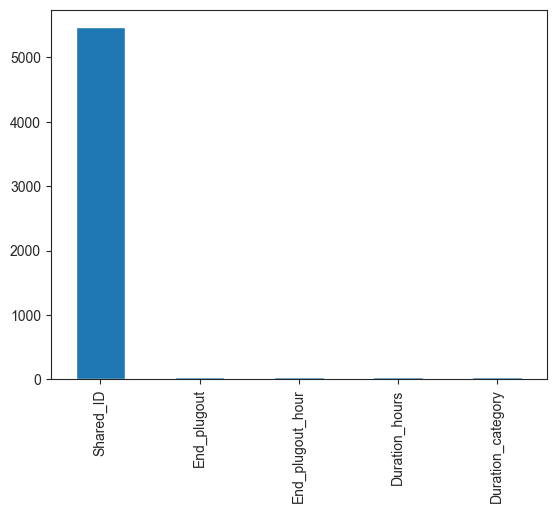

In [48]:
# visualize missing data
import seaborn as sns

sns.set_style('ticks')
missing = df1.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(ascending=False, inplace=True)
missing.plot.bar()

print(missing)
print('The number of features with missing data: %i' % missing.count())

In [49]:
df1['Shared_ID'].unique()

array([nan, 'Shared-7', 'Shared-12', 'Shared-5', 'Shared-6', 'Shared-11',
       'Shared-4', 'Shared-2', 'Shared-3', 'Shared-8', 'Shared-1',
       'Shared-10', 'Shared-9'], dtype=object)

In [50]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_ID         6878 non-null   int64         
 1   Garage_ID          6878 non-null   object        
 2   User_ID            6878 non-null   object        
 3   User_type          6878 non-null   object        
 4   Shared_ID          1412 non-null   object        
 5   Start_plugin       6878 non-null   datetime64[ns]
 6   Start_plugin_hour  6878 non-null   int64         
 7   End_plugout        6844 non-null   datetime64[ns]
 8   End_plugout_hour   6844 non-null   float64       
 9   El_kWh             6878 non-null   float64       
 10  Duration_hours     6844 non-null   float64       
 11  month_plugin       6878 non-null   object        
 12  weekdays_plugin    6878 non-null   object        
 13  Plugin_category    6878 non-null   object        
 14  Duration

In [51]:
# handling missing Shared_IDs
df1['Shared_ID'].fillna('Not_Shared', inplace=True)

/var/folders/18/8clc2py90l78rfr41n28mwfh0000gq/T/ipykernel_15235/48301390.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Shared_ID'].fillna('Not_Shared', inplace=True)


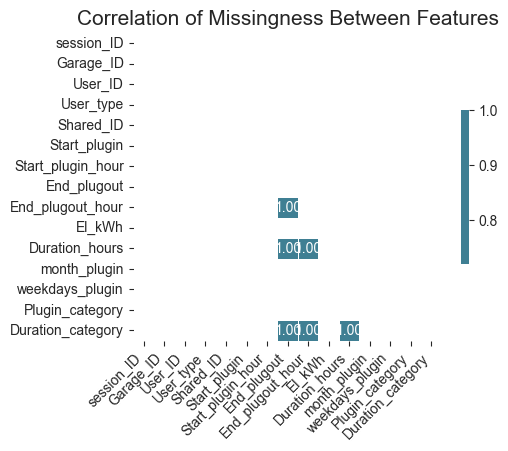

In [52]:
# correlation of missingness
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

missing_corr = df1.isna().corr()

mask = np.triu(np.ones_like(missing_corr, dtype=bool))
cmap = sns.diverging_palette(20, 220, n=200, as_cmap=True)

plt.figure(figsize=(5, 4))

sns.heatmap(missing_corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=.8, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            annot=True,
            fmt=".2f")

plt.title('Correlation of Missingness Between Features', size=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [53]:
# overlapping missing values
missing_end_plugout = df1[df1['End_plugout'].isna()]
print(missing_end_plugout[['End_plugout_hour', 'Duration_hours', 'Duration_category']].isna().sum())

End_plugout_hour     34
Duration_hours       34
Duration_category    34
dtype: int64


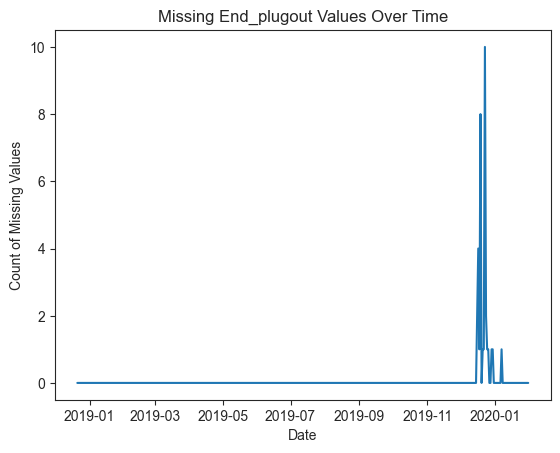

In [54]:
# temporal patterns
df1['missing_End_plugout'] = df1['End_plugout'].isna()
df1.groupby(df1['Start_plugin'].dt.date)['missing_End_plugout'].sum().plot(kind='line')
plt.title('Missing End_plugout Values Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Missing Values')
plt.show()


In [55]:
# user behavior
users_with_missing = df1[df1['End_plugout'].isna()]['User_ID'].unique()
df1[df1['User_ID'].isin(users_with_missing)].groupby('User_ID').size()

User_ID
AdA6-1      156
AsO4-2      138
AsO8-3       36
Bl2-1       278
Bl2-2       319
Bl2-3       169
Bl2-5       639
Bl2-8       149
MS22-1       59
NR1-1        89
Ris-1        42
Ris-2        46
SR2-3       131
Share-12    136
Share-15     29
Share-17     15
Share-32      2
UT1-1       135
UT15-2      116
UT7-1        29
UT7-2       116
dtype: int64

In [56]:
from scipy.stats import ttest_ind

non_missing = df1[~df1['End_plugout'].isna()]['El_kWh']
missing = df1[df1['End_plugout'].isna()]['El_kWh']
ttest_ind(non_missing, missing, nan_policy='omit')

TtestResult(statistic=0.6824710428144728, pvalue=0.4949641371704909, df=6876.0)

In [57]:
# imputing missing values 
# calculate overall average session duration
average_duration = df1['Duration_hours'].dropna().mean()

# impute missing End_plugout times
missing_indices = df1[df1['End_plugout'].isna()].index
df1.loc[missing_indices, 'End_plugout'] = df1.loc[missing_indices, 'Start_plugin'] + pd.to_timedelta(average_duration, unit='h')

End_plugout_hour     34
Duration_hours       34
Duration_category    34
dtype: int64
The number of features with missing data: 3


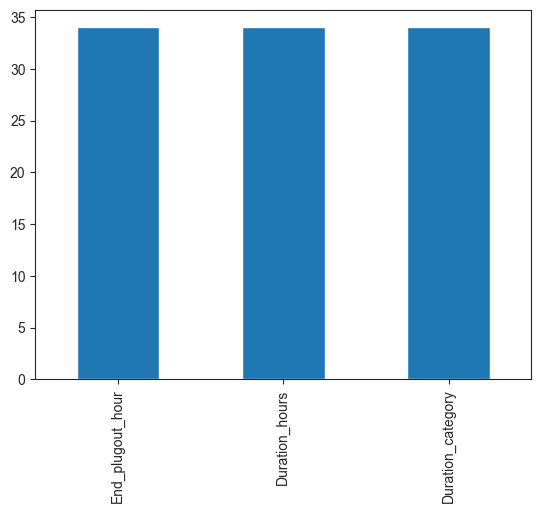

In [58]:
# visualize missing data
import seaborn as sns

sns.set_style('ticks')
missing = df1.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(ascending=False, inplace=True)
missing.plot.bar()

print(missing)
print('The number of features with missing data: %i' % missing.count())

In [59]:
# handle other missing values by recalculating columns
missing_end_plugout_hour = df1['End_plugout_hour'].isna() & df1['End_plugout'].notna()
df1.loc[missing_end_plugout_hour, 'End_plugout_hour'] = df1.loc[missing_end_plugout_hour, 'End_plugout'].dt.hour

missing_duration_hours = df1['Duration_hours'].isna() & df1['End_plugout'].notna() & df1['Start_plugin'].notna()
df1.loc[missing_duration_hours, 'Duration_hours'] = (df1.loc[missing_duration_hours, 'End_plugout'] - df1.loc[missing_duration_hours, 'Start_plugin']).dt.total_seconds() / 3600

Duration_category    34
dtype: int64
The number of features with missing data: 1


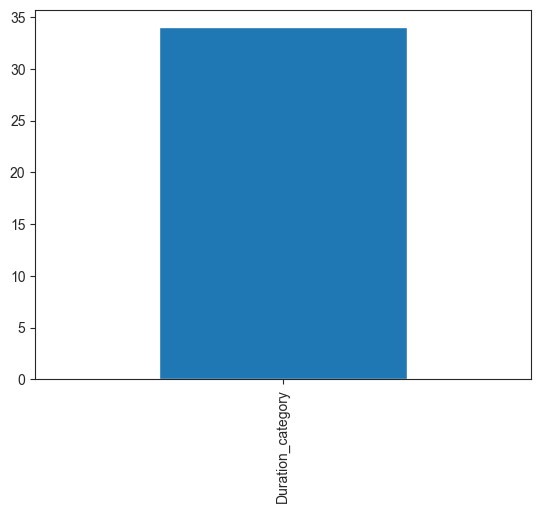

In [60]:
# visualize missing data
import seaborn as sns

sns.set_style('ticks')
missing = df1.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(ascending=False, inplace=True)
missing.plot.bar()

print(missing)
print('The number of features with missing data: %i' % missing.count())

In [61]:
df1['Duration_category'].unique()

array(['Less than 3 hours', 'Between 6 and 9  hours',
       'More than 18 hours', 'Between 3 and 6 hours',
       'Between 15 and 18 hours', 'Between 12 and 15 hours',
       'Between 9 and 12 hours', nan], dtype=object)

In [62]:
import numpy as np

# conditional logic for categories
conditions = [
    (df1['Duration_hours'] <= 3),
    (df1['Duration_hours'] > 3) & (df1['Duration_hours'] <= 6),
    (df1['Duration_hours'] > 6) & (df1['Duration_hours'] <= 9),
    (df1['Duration_hours'] > 9) & (df1['Duration_hours'] <= 12),
    (df1['Duration_hours'] > 12) & (df1['Duration_hours'] <= 15),
    (df1['Duration_hours'] > 15) & (df1['Duration_hours'] <= 18),
    (df1['Duration_hours'] > 18)
]

# categories for the conditions
categories = [
    'Less than 3 hours',
    'Between 3 and 6 hours',
    'Between 6 and 9 hours',
    'Between 9 and 12 hours',
    'Between 12 and 15 hours',
    'Between 15 and 18 hours',
    'More than 18 hours'
]

# find rows where Duration_category is missing
missing_duration_category = df1['Duration_category'].isna()

# temporary column for all rows
df1['new_duration_category'] = np.select(conditions, categories, default=np.nan)

# update 'Duration_category' where it is missing
df1.loc[missing_duration_category, 'Duration_category'] = df1.loc[missing_duration_category, 'new_duration_category']

# drop the 'new_duration_category' column
df1.drop('new_duration_category', axis=1, inplace=True)

In [63]:
# final missing value check
df1.isnull().sum()

session_ID             0
Garage_ID              0
User_ID                0
User_type              0
Shared_ID              0
Start_plugin           0
Start_plugin_hour      0
End_plugout            0
End_plugout_hour       0
El_kWh                 0
Duration_hours         0
month_plugin           0
weekdays_plugin        0
Plugin_category        0
Duration_category      0
missing_End_plugout    0
dtype: int64

In [64]:
df1.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category,missing_End_plugout
0,1,AdO3,AdO3-4,Private,Not_Shared,2018-12-21 10:20:00,10,2018-12-21 10:23:00,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours,False
1,2,AdO3,AdO3-4,Private,Not_Shared,2018-12-21 10:24:00,10,2018-12-21 10:32:00,10.0,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours,False
2,3,AdO3,AdO3-4,Private,Not_Shared,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19.0,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours,False
3,4,AdO3,AdO3-2,Private,Not_Shared,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16.0,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours,False
4,5,AdO3,AdO3-2,Private,Not_Shared,2018-12-24 22:03:00,22,2018-12-24 23:02:00,23.0,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours,False


#### check for duplicates

In [65]:
duplicates = df1.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [66]:
# inspect duplicate rows
if num_duplicates > 0:
    print(df1[duplicates])

In [67]:
df1.describe()

,session_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours
count,6878.000000,6878,6878.000000,6878,6878.000000,6878.000000,6878.000000
mean,3439.500000,2019-10-01 11:38:00.218086912,16.325240,2019-10-01 23:08:12.614637056,12.524571,12.720744,11.504440
min,1.000000,2018-12-21 10:20:00,0.000000,2018-12-21 10:23:00,0.000000,0.010000,0.003333
25%,1720.250000,2019-08-04 21:32:15,15.000000,2019-08-05 11:12:00,7.000000,5.200000,2.799444
50%,3439.500000,2019-11-02 17:53:00,17.000000,2019-11-03 11:49:00,12.000000,9.050000,10.090694
75%,5158.750000,2019-12-19 06:15:30,19.000000,2019-12-19 14:58:00,17.000000,16.090000,15.198819
max,6878.000000,2020-01-31 20:42:00,23.000000,2020-01-31 23:53:00,23.000000,80.860000,255.029444
std,1985.651908,NaN,4.363108,NaN,5.280187,11.787938,14.113150


In [68]:
# determine severity of skew

mean_value = df1['Duration_hours'].mean()
median_value = df1['Duration_hours'].median()

# calculate the difference
difference = abs(mean_value - median_value)

# calculate 20% of the mean (moderate to severe skew) or 10% of the mean (mild skew)
twenty_percent_of_mean = 0.20 * mean_value

# determine if the difference is significant
is_significant = difference > twenty_percent_of_mean

print(f"Is the difference significant? {is_significant}")

Is the difference significant? False


In [69]:
# percent difference between mean and median

mean_value = df1['Duration_hours'].mean()
median_value = df1['Duration_hours'].median()

# calculate the absolute difference between mean and median
absolute_difference = abs(mean_value - median_value)

# calculate the percentage difference
percentage_difference = (absolute_difference / mean_value) * 100

print(f"Percentage difference between mean and median: {percentage_difference:.2f}%")


Percentage difference between mean and median: 12.29%


In [70]:
# iqr relative to the median 

import pandas as pd

# calculate the 25th and 75th percentiles (Q1 and Q3)
Q1 = df1['Duration_hours'].quantile(0.25)
Q3 = df1['Duration_hours'].quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# calculate the median
median_value = df1['Duration_hours'].median()

# calculate the IQR as a proportion of the median
IQR_proportion = IQR / median_value

print(f"IQR as a proportion of the median: {IQR_proportion:.2f}")

IQR as a proportion of the median: 1.23


some statistics of interest:
- *El_kWh*: mean: 12.72, std: 11.79, range: 0.01-80.86, 50% (median): 9.05
- *Duration_hours*: mean: 11.50, std: 14.11, range: 0.003-255.03, 50% (median): 10.09

median to mean comparison to understand skewness:
- *El_kWh*: mean: 12.72 vs median: 9.05, interpretation: suggests skewness. the mean is more affected by outliers and extreme values. the difference suggests the mean is being pulled away from the median and also that the distribution is significantly skewed (a difference beyond 20%). percent difference: 28.86%.
- *Duration_hours*: mean: 11.50 vs median: 10.09, interpretation: suggests skewness. the mean is more affected by outliers and extreme values. the difference suggests the mean is being pulled away from the median and also that there is a mild skew (a difference within 10%). percent difference: 12.29%.

interpreting percentiles:
- *El_kWh*: spread (IQR): (25%) 5.20 - (75%) 16.09, distribution shape: the data piles up more quickly on the lower end and spreads out toward the higher end, tail length and outliers (75% v max): the difference suggests the presence of outliers. the iqr as a proportion of the median: 1.20. the ratio is slightly abouve 1, indicating the iqr is spread out over a wide range.
- *Duration_hours*: spread (IQR): (25%) 2.80 - (75%) 15.20, distribution shape: the data piles up more quickly on the lower end and spreads out toward the higher end, tail length and outliers (75% v max):  the difference suggests the presence of outliers. the iqr as a proportion of the median: 1.23. the ratio is slightly abouve 1, indicating the iqr is spread out over a wide range.

other notes:
- *El_kWh* and *Duration_hours* have high standard deviations suggesting values are spread out over a wide range, indicating variability in charging session lengths and energy consumption.
- the wide range in both *El_kWh* and *Duration_hours* might indicate the presence of outliers. a **box plot** can help visualize outliers. 
- the mean vs median comparison shows both distributions are right-skewed (positive skew)
- depending on the machine learning models to be used, it may be necessary to normalize or standardize data for alorithms that are sensitive to the scale of data. in addition, data transformation may be necessary given the presence of skewness before applying machine learning models.
- other visualizations: **histograms**, **density plots**, **scatter plots**, and **time series plots** for temporal patterns.

### EDA

#### histograms and density plots
understand the distribution of variables of interest and identify skewness, peaks, and the spread of dta.

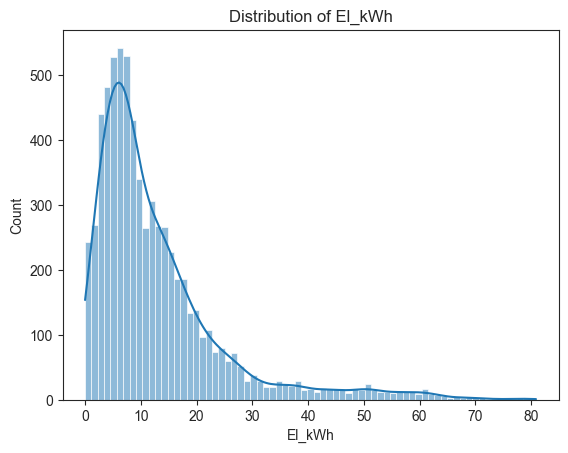

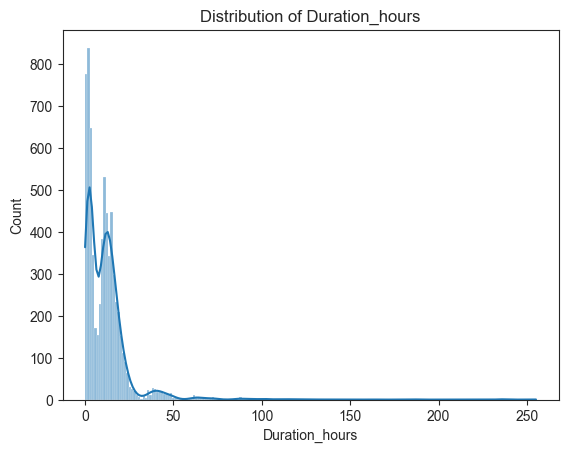

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# El_kWh
sns.histplot(df1['El_kWh'], kde=True)
plt.title('Distribution of El_kWh')
plt.show()

# Duration_hours
sns.histplot(df1['Duration_hours'], kde=True)
plt.title('Distribution of Duration_hours')
plt.show()

#### box plots
visualize the quartiles of the data and identify outliers. they show the median, iqr, and potential outliers.

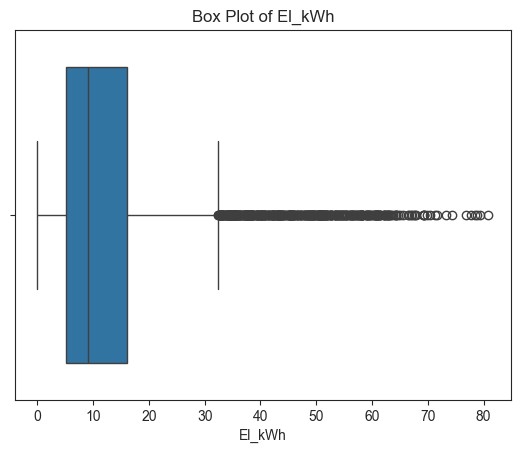

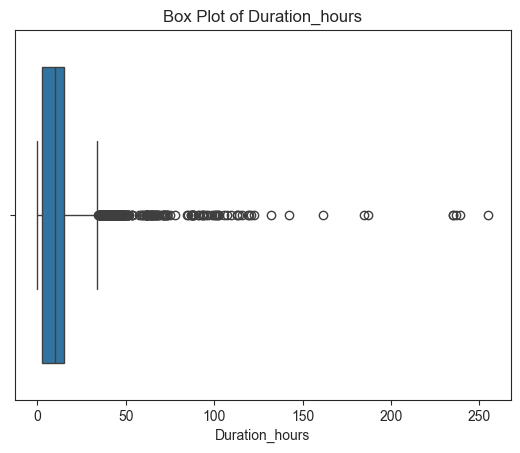

In [72]:
# El_kWh
sns.boxplot(x=df1['El_kWh'])
plt.title('Box Plot of El_kWh')
plt.show()

# Duration_hours
sns.boxplot(x=df1['Duration_hours'])
plt.title('Box Plot of Duration_hours')
plt.show()


#### scatter plots
explore the relationship between two variables to identify patterns, trends, and potential correlations.

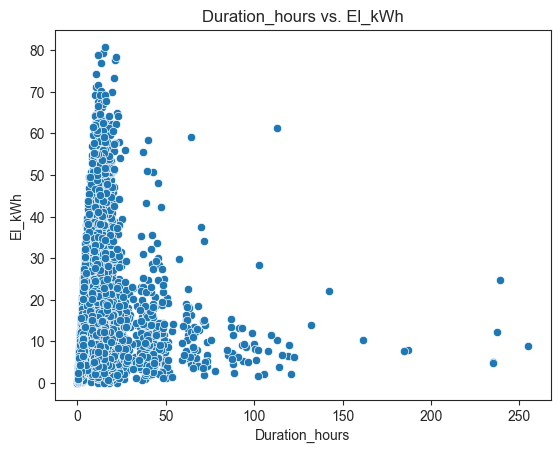

In [73]:
sns.scatterplot(x='Duration_hours', y='El_kWh', data=df1)
plt.title('Duration_hours vs. El_kWh')
plt.xlabel('Duration_hours')
plt.ylabel('El_kWh')
plt.show()

#### time series plots
reveal temporal patterns to identify cyclic trends, seasonal variations, or anomalies over time.

In [74]:
df1['Start_plugin'] = pd.to_datetime(df1['Start_plugin'])
df1.set_index('Start_plugin', inplace=True)

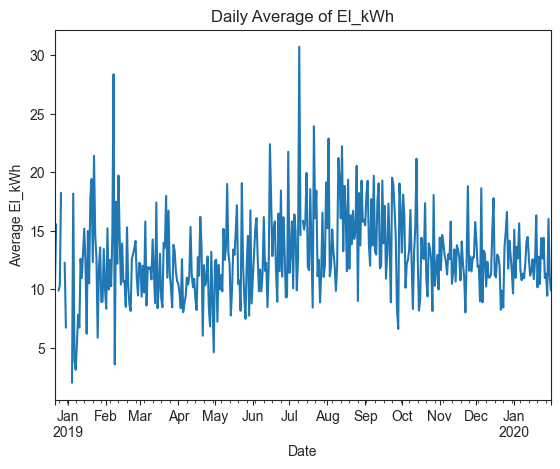

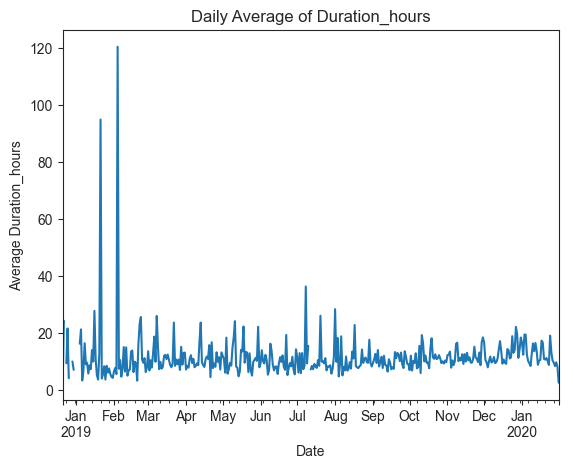

In [75]:
# daily average

# El_kWh
df1['El_kWh'].resample('D').mean().plot(title='Daily Average of El_kWh')
plt.ylabel('Average El_kWh')
plt.xlabel('Date')
plt.show()

# Duration_hours
df1['Duration_hours'].resample('D').mean().plot(title='Daily Average of Duration_hours')
plt.ylabel('Average Duration_hours')
plt.xlabel('Date')
plt.show()

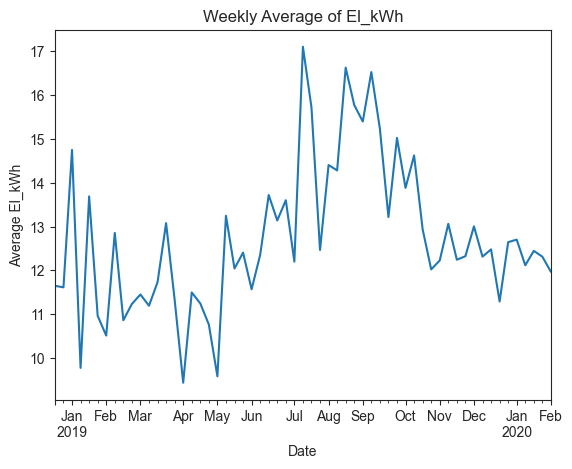

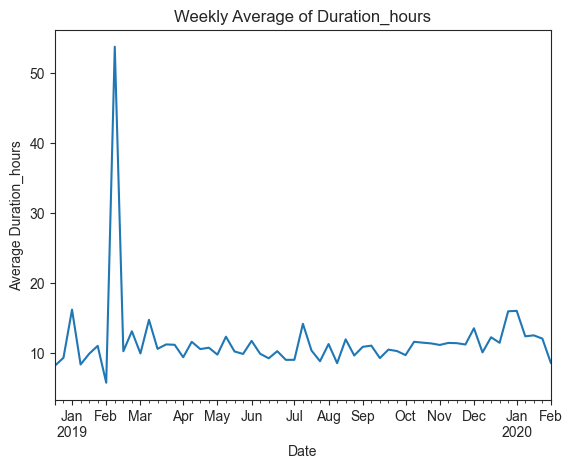

In [78]:
# weekly average

# El_kWh
df1['El_kWh'].resample('W').mean().plot(title='Weekly Average of El_kWh')
plt.ylabel('Average El_kWh')
plt.xlabel('Date')
plt.show()

# Duration_hours
df1['Duration_hours'].resample('W').mean().plot(title='Weekly Average of Duration_hours')
plt.ylabel('Average Duration_hours')
plt.xlabel('Date')
plt.show()

/var/folders/18/8clc2py90l78rfr41n28mwfh0000gq/T/ipykernel_15235/4217345416.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df1['El_kWh'].resample('M').mean().plot(title='Monthly Average of El_kWh')


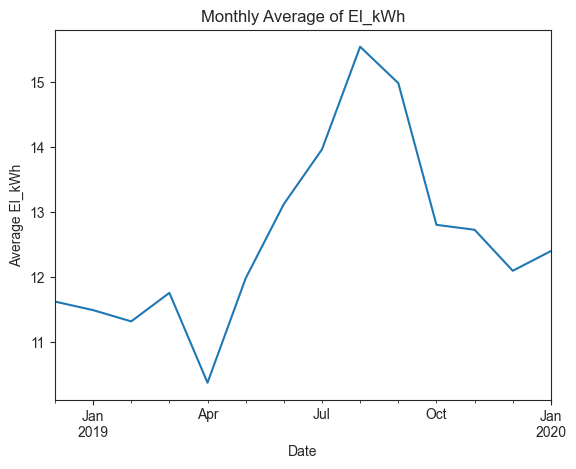

/var/folders/18/8clc2py90l78rfr41n28mwfh0000gq/T/ipykernel_15235/4217345416.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df1['Duration_hours'].resample('M').mean().plot(title='Monthly Average of Duration_hours')


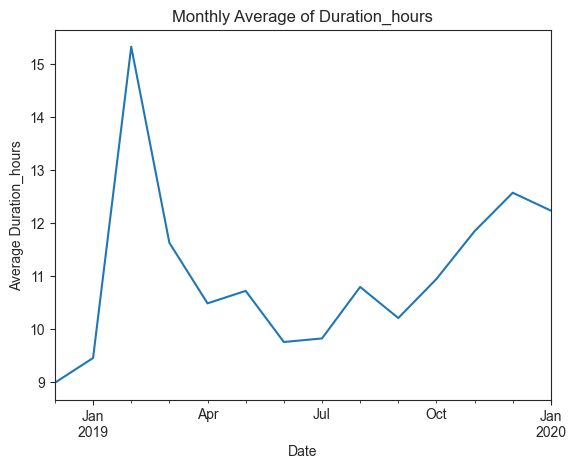

In [79]:
# monthly average

# El_kWh
df1['El_kWh'].resample('M').mean().plot(title='Monthly Average of El_kWh')
plt.ylabel('Average El_kWh')
plt.xlabel('Date')
plt.show()

# Duration_hours
df1['Duration_hours'].resample('M').mean().plot(title='Monthly Average of Duration_hours')
plt.ylabel('Average Duration_hours')
plt.xlabel('Date')
plt.show()

# weather data

In [76]:
# load dataset 7
df7_path = 'data/7 norway trondheim exact location weather.csv'
df7 = pd.read_csv(df7_path, delimiter=',')

In [77]:
df7.head()

,Unnamed: 0,clouds,datetime,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
0,0,66,2018-12-01,-1.7,5,40,6,34,288,48,...,2,127,966,144,52,7.4,1543618800,187,12.8,5.5
1,1,64,2018-12-02,-2.8,5,38,6,33,281,46,...,5,123,923,135,126,5.4,1543705200,177,10.8,3.6
2,2,100,2018-12-03,-0.7,5,37,5,33,273,44,...,1,119,881,128,21,2.4,1543791600,142,4.8,1.5
3,3,93,2018-12-04,-0.5,5,35,5,32,266,42,...,1,115,842,121,22,0.8,1543878000,234,12.8,3.9
4,4,87,2018-12-05,-1.9,5,34,5,32,260,41,...,2,111,804,114,39,-0.4,1543964400,206,13.6,3.7
